# 1. 1ntroduction to JumpStart - Text to Image

***

Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)에 오신 것을 환영합니다! SageMaker Studio에서 한 번의 클릭으로 또는 [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart)를 통해 JumpStart를 사용하여 많은 머신러닝 작업을 해결할 수 있습니다. 이 데모 노트북에서는 최신 안정 확산 모델을 사용하여 텍스트에서 이미지를 생성하기 위해 JumpStart API를 사용하는 방법을 보여줍니다. 또한 데이터 세트에 맞게 모델을 미세 조정하는 방법도 보여드립니다.

Stable Diffusion은 text prompt만으로 사실적인 이미지를 생성할 수 있는 text-to-image model입니다. diffusion 모델은 실제 이미지에 추가된 노이즈를 제거하는 방법을 학습하여 훈련합니다. 이 노이즈 제거 과정을 통해 사실적인 이미지가 생성됩니다. 이러한 모델은 텍스트에 대한 생성 프로세스를 조절하여 텍스트만으로 이미지를 생성할 수도 있습니다. 예를 들어, Stable Diffusion은 모델이 순수한 노이즈 이미지에서 도형을 인식하는 방법을 학습하고 입력 텍스트의 단어와 도형이 일치하는 경우 점차적으로 이러한 도형에 초점을 맞추는 latent diffusion입니다.

대규모 모델을 훈련 및 배포하고 안정 확산과 같은 모델에서 추론을 실행하는 것은 종종 메모리 부족, 페이로드 크기 제한 초과 등과 같은 문제를 포함하여 까다로운 작업입니다. JumpStart는 강력한 테스트를 거친 바로 사용할 수 있는 스크립트를 제공하여 이 프로세스를 간소화합니다. 또한 권장 인스턴스 유형, 이미지 생성 프로세스를 안내하는 매개변수 선택 방법, prompt engineering 등 프로세스의 각 단계에 대한 지침을 제공합니다. 또한 코드를 직접 작성하지 않고도 JumpStart의 80개 이상의 Diffusion 모델 중 하나에 추론을 배포하고 실행할 수 있습니다.

이 notebook에서는 JumpStart를 사용하여 피사체/객체/환경/장면의 매우 사실적이고 예술적인 이미지를 생성하는 방법을 배웁니다. 귀여운 강아지 이미지처럼 단순할 수도 있고, 극적인 일몰 조명과 영화 같은 분위기의 긴 그림자가 있는 greg rutkowski 스타일의 픽셀러로 아름답게 장식된 아늑한 주방의 초현실적인 이미지처럼 디테일할 수도 있습니다. 전자 상거래 비즈니스 요구에 맞는 제품을 디자인하고 카탈로그를 구축하거나 사실적인 예술 작품이나 스톡 이미지를 생성하는 데 사용할 수 있습니다.

Model 라이선스: 이 모델을 사용하면, 여러분들은 [CreativeML Open RAIL-M++ license](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL)에 동의하는 것입니다.

***

1. [Set Up](#1.-Set-Up)
2. [Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model)
    * [Select a model](#2.1.-Select-a-Model)
    * [Retrieve JumpStart Artifacts & Deploy an Endpoint](#2.2.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
    * [Query endpoint and parse response](#2.3.-Query-endpoint-and-parse-response)
    * [Supported Inference parameters](#2.4.-Supported-Inference-parameters)
    * [Compressed Image Output](#2.5.-Compressed-Image-Output)
    * [Prompt Engineering](#2.6.-Prompt-Engineering)
    * [Clean up the endpoint](#2.7.-Clean-up-the-endpoint)
3. [Conclusion](#3.-Conclusion)


참고: 이 노트북은 Python 3 (Data Science) 커널이 포함된 Amazon SageMaker Studio의 ml.t3.medium 인스턴스와 conda_python3 커널이 포함된 Amazon SageMaker Notebook 인스턴스에서 테스트되었습니다.

참고: 사전 학습된 모델을 배포하려면 `ml.p3.2xlarge` 또는 `ml.g4dn.2xlarge` 인스턴스 유형을 사용할 수 있습니다. 해당 region에서 `ml.g5.2xlarge`를 사용할 수 있는 경우 해당 인스턴스 유형을 배포에 사용하는 것이 좋습니다. 

### 1. Set Up

***
노트북을 실행하기 전에 설정에 필요한 몇 가지 initial 단계가 있습니다. 이 노트북에는 최신 버전의 sagemaker와 ipywidgets가 필요합니다.

***

In [3]:
!pip install ipywidgets==7.0.0 --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


#### Permissions and environment variables

***
Amazon SageMaker에서 호스팅하려면 AWS 서비스 사용을 설정하고 인증해야 합니다. 여기서는 현재 노트북과 연결된 실행 역할을 SageMaker 액세스 권한이 있는 AWS 계정 역할로 사용합니다.

***

In [5]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

In [6]:
# Run this cell to import or install the Data Wrangler widget to show automatic visualization and generate code to fix data quality issues

try:
    import sagemaker_datawrangler
except ImportError:
    !pip install --upgrade sagemaker-datawrangler
    import sagemaker_datawrangler

# Display Pandas DataFrame to view the widget: df, display(df), df.sample()... 

## 2. Run inference on the pre-trained model

***
JumpStart를 사용하면 새로운 데이터 세트에 대해 먼저 미세 조정하지 않고도 pre-trained model에 대해 추론을 수행할 수 있습니다.
***

### 2.1. Select a Model
***
default 모델을 계속 사용하거나 다음 셀을 실행할 때 생성되는 드롭다운에서 다른 모델을 선택할 수 있습니다. 또한, SageMaker pre-trained 모델의 전체 목록은 [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#) 에서도 확인할 수 있습니다.

***

In [7]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text-to-Image generation models.
filter_value = "task == txt2img"
txt2img_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=txt2img_models,
    value="model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

A Jupyter Widget

In [8]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

### 2.2. Retrieve JumpStart Artifacts & Deploy an Endpoint

***

JumpStart를 사용하면 새로운 데이터 세트에서 먼저 fine-tuning하지 않고도 사전 학습된 모델에 대해 추론을 수행할 수 있습니다. 먼저 사전 학습된 모델에 대한 `deploy_image_uri`, `deploy_source_uri`, `model_uri`를 검색합니다. 사전 학습된 모델을 호스팅하기 위해 [sagemaker.model.Model](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html)의 인스턴스를 생성하고 배포합니다.

### 최대 10분 정도 소요될 수 있습니다. 기다리는 동안 커널을 종료하지 마세요.

기다리는 동안 [Generate images from text with the stable diffusion model on Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/generate-images-from-text-with-the-stable-diffusion-model-on-amazon-sagemaker-jumpstart/)를 확인하여 Stable Diffusion 모델과 JumpStart에 대해 자세히 알아볼 수 있습니다.

***

In [9]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
# inference_instance_type = "ml.p3.2xlarge"
inference_instance_type = "ml.g5.xlarge"
# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the model uri. This includes the pre-trained nvidia-ssd model and parameters.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# To increase the maximum response size from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

----------!

### 2.3. Query endpoint and parse response

***

endpoint에 대한 입력은 json으로 `utf-8` 형식으로 인코딩된 모든 텍스트 문자열입니다. 엔드포인트의 출력은 생성된 텍스트가 포함된 `json`입니다.

***

In [10]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

***
아래는 몇 가지 입력 텍스트 예시입니다. 어떤 텍스트든 입력하면 모델이 해당 텍스트에 해당하는 이미지를 예측합니다.

***

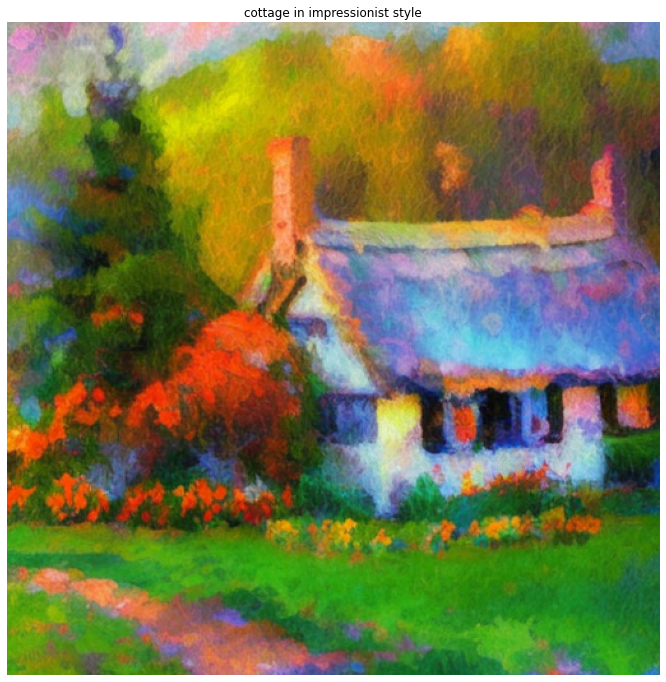

In [11]:
text = "cottage in impressionist style"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

### 2.4. Supported Inference parameters

***
This model also supports many advanced parameters while performing inference. They include:

* **prompt**: 이미지 생성을 안내하는 프롬프트입니다. 반드시 지정해야 하며 문자열 또는 문자열 목록일 수 있습니다.
* **width**: 생성 이미지의 너비. 지정할 경우 8로 나눌 수 있는 양의 정수여야 합니다.
* **height**: 생성 이미지의 높이. 지정한 경우 8로 나눌 수 있는 양의 정수여야 합니다.
* **num_inference_steps**: 이미지 생성 중 denoising 단계의 수입니다. 단계가 많을수록 이미지 품질이 높아집니다. 지정하면 양수여야 합니다.
* **guidance_scale**: guidance_scale가 높을수록 이미지 품질은 떨어지더라도 프롬프트와 밀접하게 관련된 이미지를 얻을 수 있습니다. 지정한 경우 반드시 실수여야 하며, guidance_scale<=1은 무시됩니다.
* **negative_prompt**: 이 프롬프트에 반대되는 이미지를 생성합니다. 지정하는 경우 string 또는 string의 list이어야 하며, guidance_scale과 함께 사용해야 합니다. guidance_scale이 비활성화되면 이 옵션도 비활성화됩니다. 또한 프롬프트가 string의 list인 경우 negative_prompt도 string의 list이어야 합니다. 
* **num_images_per_prompt**: 프롬프트당 반환되는 이미지 수입니다. 지정한 경우 양수여야 합니다. 
* **seed**: 재현성을 위해 무작위 상태를 수정합니다. 지정하면 반드시 정수여야 합니다.

***

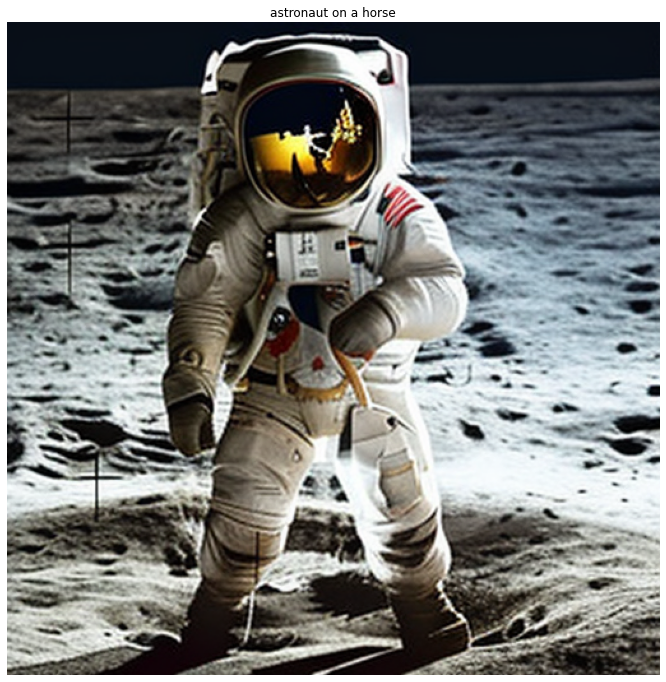

In [12]:
import json

# Training data for different models had different image sizes and it is often observed that the model performs best when the generated image
# has dimensions same as the training data dimension. For dimensions not matching the default dimensions, it may result in a black image.
# Stable Diffusion v1-4 was trained on 512x512 images and Stable Diffusion v2 was trained on 768x768 images.
payload = {
    "prompt": "astronaut on a horse",
    "width": 512,
    "height": 512,
    "num_images_per_prompt": 1,
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
}


def query_endpoint_with_json_payload(model_predictor, payload, content_type, accept):
    """Query the model predictor with json payload."""

    encoded_payload = json.dumps(payload).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response_multiple_images(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]


query_response = query_endpoint_with_json_payload(
    model_predictor, payload, "application/json", "application/json"
)
generated_images, prompt = parse_response_multiple_images(query_response)

for img in generated_images:
    display_img_and_prompt(img, prompt)

### 2.5. Compressed Image Output

---

엔드포인트의 default response type은 RGB 값의 중첩된 배열이며, 생성된 이미지 크기가 큰 경우 응답 크기 제한에 걸릴 수 있습니다. 이 문제를 해결하기 위해 각 이미지가 바이트 단위로 반환되는 JPEG 이미지로 반환되는 엔드포인트 응답도 지원합니다. 이렇게 하려면 `Accept = 'application/json;jpeg'`를 설정하세요.

---

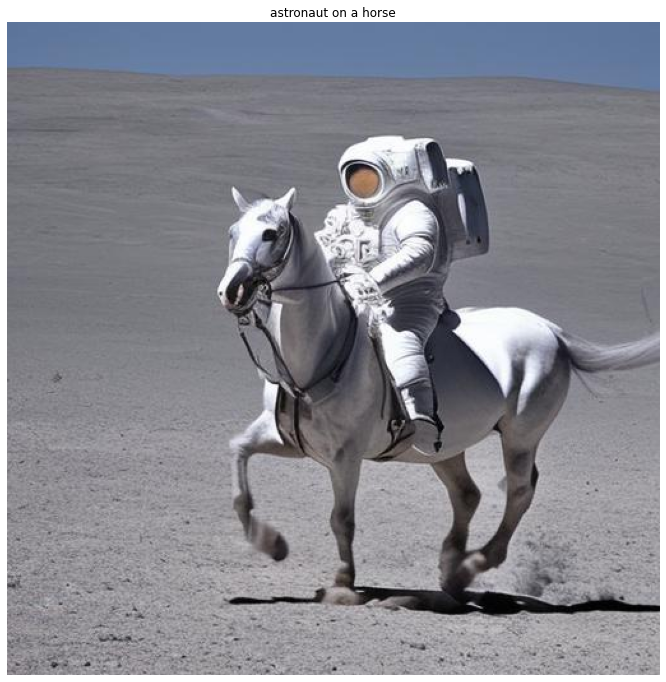

In [13]:
from PIL import Image
from io import BytesIO
import base64
import json

query_response = query_endpoint_with_json_payload(
    model_predictor, payload, "application/json", "application/json;jpeg"
)
generated_images, prompt = parse_response_multiple_images(query_response)

# generated_images are a list of jpeg images as bytes with b64 encoding.


def display_encoded_images(generated_images, prompt):
    # we decode the images and convert to RGB format before displaying
    for generated_image in generated_images:
        generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
        generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
        display_img_and_prompt(generated_image_rgb, prompt)


display_encoded_images(generated_images, prompt)

### 2.6. Prompt Engineering
---

좋은 프롬프트를 작성하는 것은 때때로 예술이 될 수 있습니다. 특정 프롬프트가 주어진 모델에서 만족스러운 이미지를 얻을 수 있는지 예측하기 어려운 경우가 많습니다. 하지만 효과가 있는 것으로 관찰된 특정 템플릿이 있습니다. 프롬프트는 크게 (i) 이미지 (photograph/sketch/painting etc.)의 유형, (ii) 설명 (subject/object/environment/scene etc.), (iii) 이미지 스타일 (realistic/artistic/type of art etc.)의 세 부분으로 나눌 수 있습니다. 세 가지 부분을 각각 개별적으로 변경하여 이미지의 변형을 생성할 수 있습니다. 형용사는 이미지 생성 과정에서 중요한 역할을 하는 것으로 알려져 있습니다. 또한 세부 사항을 추가하면 생성 과정에 도움이 됩니다.

사실적인 (realistic) 이미지를 생성하려면 "a photo of", "a photograph of", "realistic" 또는 "hyper realistic"과 같은 문구를 사용할 수 있습니다. 아티스트별 이미지를 생성하려면 "by Pablo   Piccaso", "oil painting by Rembrandt", "landscape art by Frederic Edwin Church", "pencil drawing by Albrecht Dürer" 등의 문구를 사용할 수 있습니다. 또한, 여러 아티스트를 결합할 수도 있습니다. 카테고리별로 예술적 이미지를 생성하려면 "lion on a beach, abstract"과 같이 프롬프트에 예술 카테고리를 추가하면 됩니다. 다른 카테고리로는 "oil painting", "pencil drawing", “pop art”, “digital art”, “anime”, “cartoon”, “futurism”, “watercolor”, “manga” 등이 있습니다. 또한, 조명 (lighting)이나 카메라 렌즈(35mm wide lens 또는 85mm wide lens 등), framing (portrait/landscape/close up etc.)에 대한 세부 정보도 포함할 수 있습니다.

동일한 프롬프트가 여러 번 주어지더라도 모델은 다른 이미지를 생성합니다. 따라서 여러 이미지를 생성하여 용도에 가장 적합한 이미지를 선택할 수 있습니다.

---

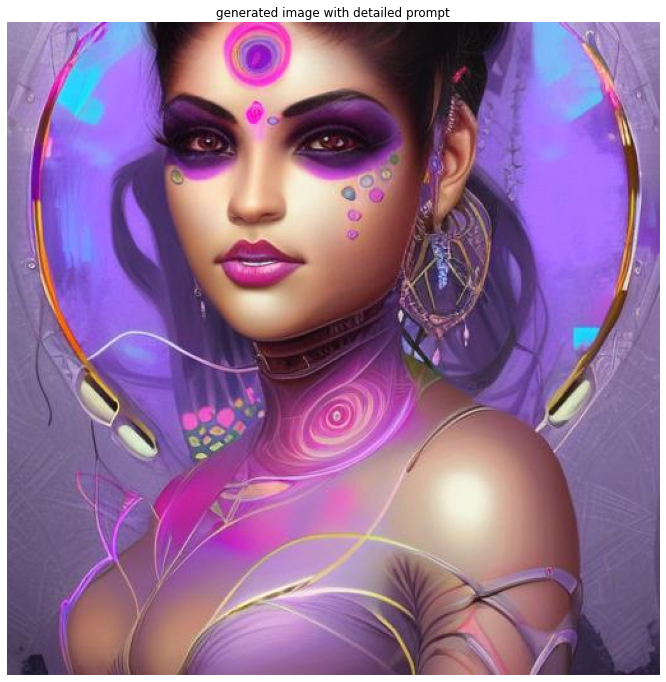

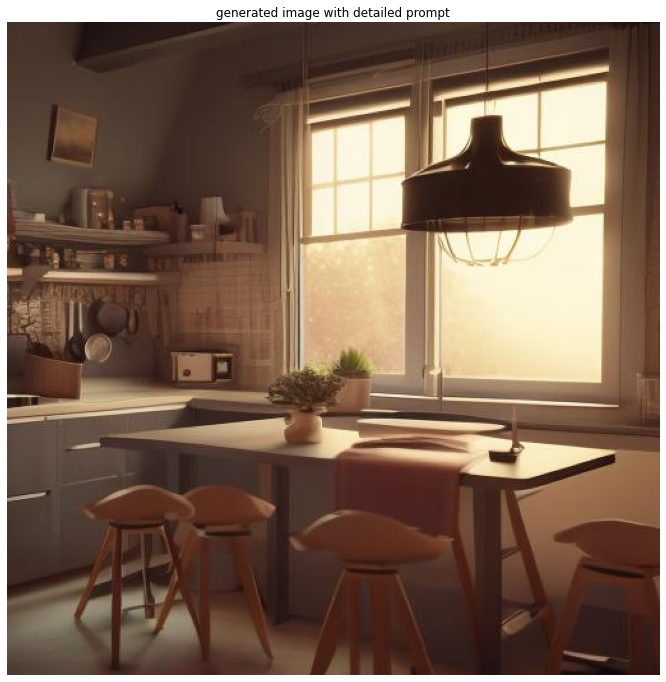

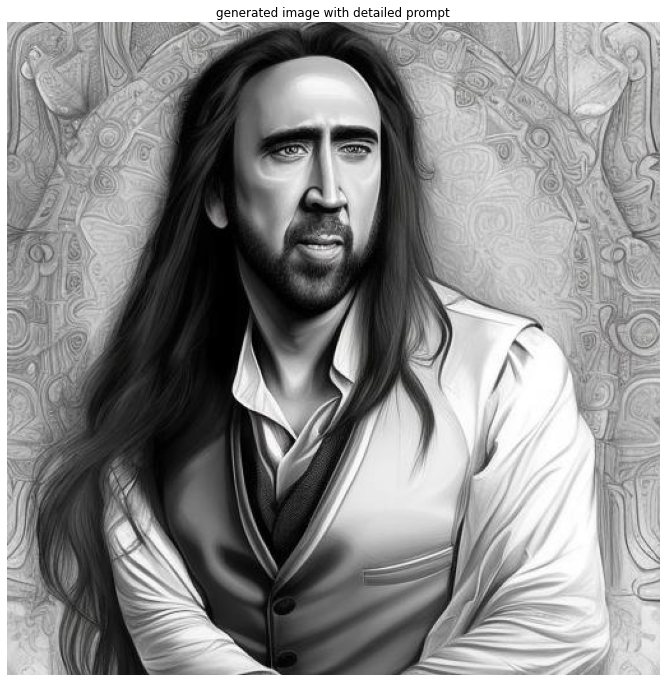

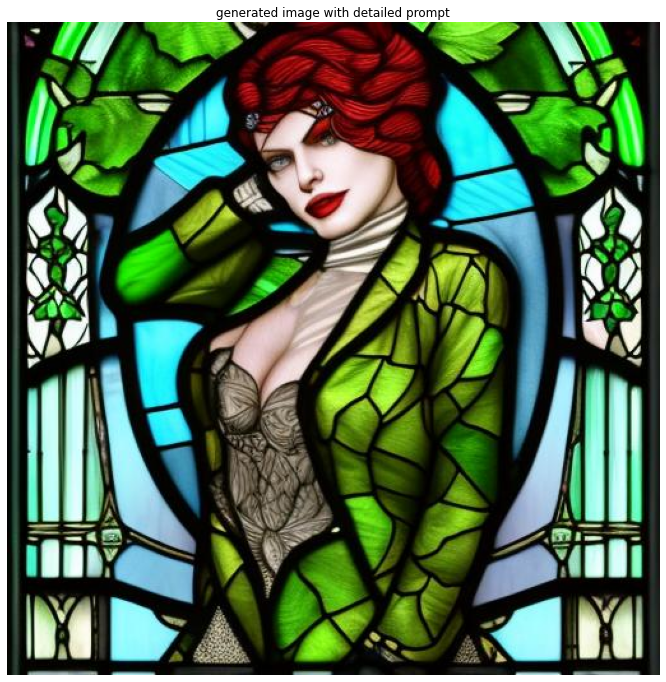

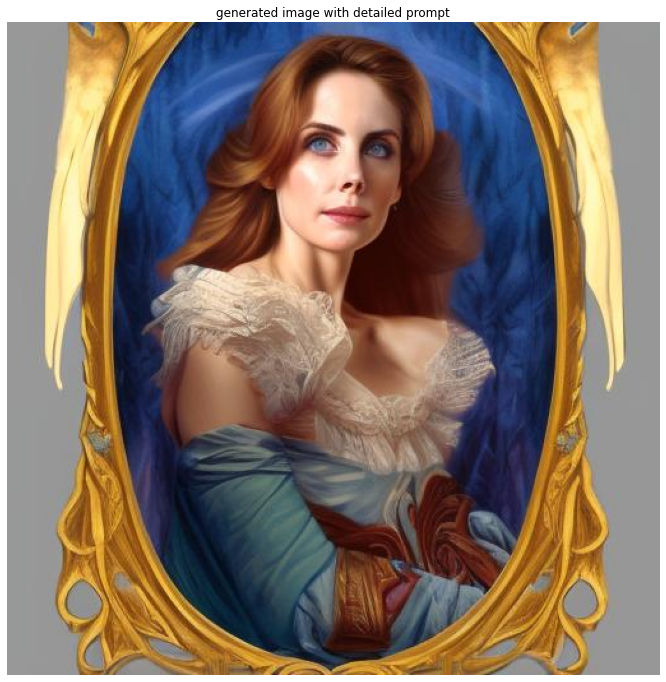

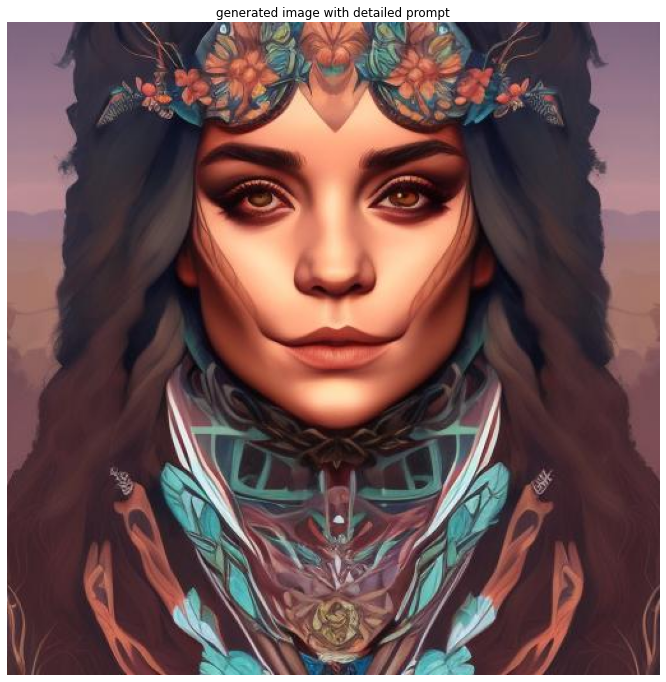

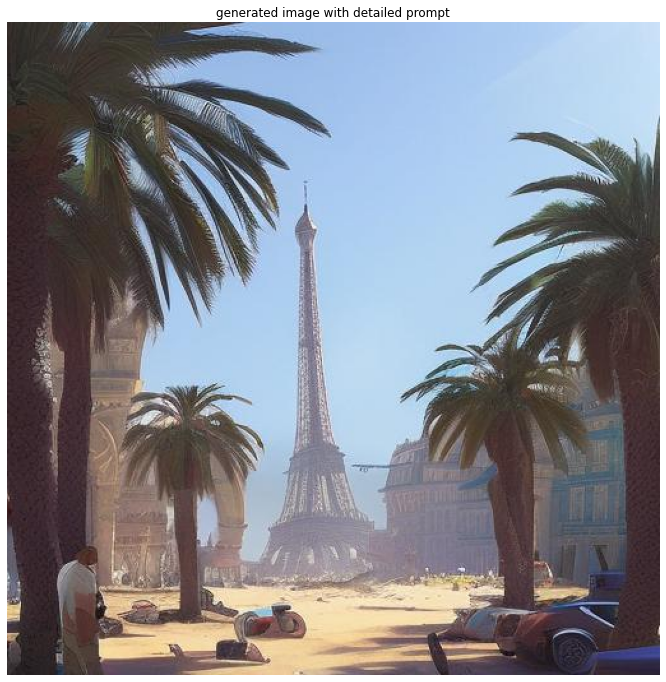

In [14]:
prompts = [
    "a beautiful illustration of a young cybertronic hyderabadi american woman, round face, cateye glasses, purple colors, intricate, sharp focus, illustration, highly detailed, digital painting, concept art, matte, art by wlop and artgerm and greg rutkowski and alphonse mucha, masterpiece",
    "a photorealistic hyperrealistic render of an interior of a beautifully decorated cozy kitchen by pixar, greg rutkowski, wlop, artgerm, dramatic moody sunset lighting, long shadows, volumetric, cinematic atmosphere, octane render, artstation, 8 k",
    "symmetry!! portrait of nicolas cage, long hair in the wind, smile, happy, white vest, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha",
    "a stunningly detailed stained glass window of a beautiful poison ivy with green skin wearing a business suit, dark eyeliner, intricate, elegant, highly detailed, digital painting, artstation, concept art, sharp focus, illustration, art by greg rutkowski and alphonse mucha",
    "a fantasy style portrait painting of rachel lane / alison brie / sally kellerman hybrid in the style of francois boucher oil painting unreal 5 daz. rpg portrait, extremely detailed artgerm greg rutkowski alphonse mucha",
    "symmetry!! portrait of vanessa hudgens in the style of horizon zero dawn, machine face, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha, 8 k",
    "landscape of the beautiful city of paris rebuilt near the pacific ocean in sunny california, amazing weather, sandy beach, palm trees, splendid haussmann architecture, digital painting, highly detailed, intricate, without duplication, art by craig mullins, greg rutkwowski, concept art, matte painting, trending on artstation",
]
for prompt in prompts:
    payload = {"prompt": prompt, "width": 512, "height": 512}
    query_response = query_endpoint_with_json_payload(
        model_predictor, payload, "application/json", "application/json;jpeg"
    )
    generated_images, prompt = parse_response_multiple_images(query_response)
    display_encoded_images(generated_images, "generated image with detailed prompt")

### 2.7. Clean up the endpoint

In [15]:
# Delete the SageMaker endpoint
model_predictor.delete_model()
model_predictor.delete_endpoint()

### 3. Conclusion
---
이 tutorial에서는 JumpStart를 사용하여 사전 학습된 Stable Diffusion 모델을 SageMaker에 배포하는 방법을 배웠습니다. Stable Diffusion 모델은 텍스트에서 매우 사실적인 이미지를 생성할 수 있다는 것을 확인했습니다. JumpStart는 Stable Diffusion 1과 Stable Diffusion 2 및 해당 FP16 리비전을 모두 제공합니다. 또한 다양한 테마와 다양한 언어의 이미지를 생성하도록 학습된 84개의 diffusion 모델을 추가로 제공합니다. 이러한 모델은 코드를 직접 작성하지 않고도 배포할 수 있습니다.  특정 모델을 배포하려면 [2.1. Select a Model](#2.1.-Select-a-Model)의 드롭다운 메뉴에서 `model_id`를 선택하면 됩니다.

추론 과정에서 적절한 파라미터를 선택해 이미지 생성 과정을 조정할 수 있습니다. 이러한 매개변수를 설정하는 방법에 대한 가이드는 [2.4. Supported Inference parameters](#2.4.-Supported-Inference-parameters)에서 확인할 수 있습니다. 또한 대용량 이미지 페이로드를 반환하면 응답 크기 제한 문제가 발생할 수 있음을 확인했습니다. JumpStart는 엔드포인트에서 이미지를 인코딩하고 노트북에서 디코딩한 후 표시함으로써 이 문제를 처리합니다. 마지막으로, 신속한 엔지니어링이 고품질 이미지를 생성하는 데 얼마나 중요한 단계인지 살펴보았습니다. 프롬프트를 직접 설정하는 방법에 대해 논의하고 좋은 프롬프트의 몇 가지 예를 살펴봤습니다.

사전 학습된 Stable Diffusion 모델에 대한 추론에 대해 자세히 알아보려면 블로그 [Generate images from text with the stable diffusion model on Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/generate-images-from-text-with-the-stable-diffusion-model-on-amazon-sagemaker-jumpstart/)를 참조하세요.